# Part 5 - Trading Strategy

By analysis, the best model is combination of arima and rnn_gru_dropout

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
from basic_io import value_timeconvert, int_index
from basic_io import DataReader, DataSplit

[NbConvertApp] Converting notebook basic_io.ipynb to python
[NbConvertApp] Writing 6162 bytes to basic_io.py


In [8]:
import matplotlib.pyplot as plt

Prepare Data

In [2]:
instance = DataReader('price')
feature_list = ['price-volatility', 'daily-transactions', 'chain-value-density',
                'hash-rate', 'inflation', 'LTC-USD', 'market-cap', 'miner-revenue',
                'transaction-amount', 'transaction-fees', 'transaction-size', 'transaction-value']
for feature in feature_list:    
    instance.update_columns(feature)
instance.format_data()
trading_date_list = instance.get_trading_date()
instance.unprep_data['return'] =  instance.unprep_data['Bitcoin Core (BTC) Price'].pct_change().replace(np.inf,0).fillna(0).values
daily_return = instance.unprep_data['return']
df_list = [daily_return]
for i in range(1, 7):
    df_list.append(daily_return.shift(-i))
    daily_return= reduce(lambda  left,right: pd.concat([left,right], axis=1), df_list)
daily_return = np.mean(daily_return, axis=1).fillna(0)
daily_return = daily_return.fillna(0)
data = DataSplit(instance.unprep_data, daily_return, 20100101, 20180630, 20181231, 20190831, 7)

Prepare Model

In [3]:
from model import mae, rmse, decide_weight, combine_model
from model import Model, BenchPredict, NN, RNN, Arma
RNN_model = RNN(data_model=data, lb=28, la=1) # -- RNN CLASS
ARMA_data = DataSplit(instance.unprep_data, instance.unprep_data['return'], 20100101, 20180630, 20181231, 20190831, 7) # -- ARMA DATA PROCESS
ARMA_model = Arma(data_model=ARMA_data) # -- ARMA CLASS
Embed_model = combine_model(RNN_model, ARMA_model)

Using TensorFlow backend.
[NbConvertApp] Converting notebook model.ipynb to python
[NbConvertApp] Writing 19355 bytes to model.py






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 28, 10)            900       
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                1860      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 2,781
Trainable params: 2,781
Non-trainable params: 0
_________________________________________________________________
None

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3103 samples, validate on 178 samples
Epoch 1/50
3103/3103 [==============================] - 6s 2ms/step - loss: 0.1424 - mean_squared_error: 0.0392 - v

3103/3103 [==============================] - 2s 654us/step - loss: 0.0102 - mean_squared_error: 2.4762e-04 - val_loss: 0.0089 - val_mean_squared_error: 1.1852e-04
Epoch 34/50
3103/3103 [==============================] - 2s 687us/step - loss: 0.0106 - mean_squared_error: 2.5363e-04 - val_loss: 0.0087 - val_mean_squared_error: 1.3063e-04
Epoch 35/50
3103/3103 [==============================] - 2s 626us/step - loss: 0.0104 - mean_squared_error: 2.4990e-04 - val_loss: 0.0096 - val_mean_squared_error: 1.4426e-04
Epoch 36/50
3103/3103 [==============================] - 2s 622us/step - loss: 0.0101 - mean_squared_error: 2.5099e-04 - val_loss: 0.0072 - val_mean_squared_error: 9.8888e-05
Epoch 37/50
3103/3103 [==============================] - 2s 644us/step - loss: 0.0103 - mean_squared_error: 2.4941e-04 - val_loss: 0.0077 - val_mean_squared_error: 1.0272e-04
Epoch 38/50
3103/3103 [==============================] - 2s 616us/step - loss: 0.0100 - mean_squared_error: 2.3305e-04 - val_loss: 0.0071

In [4]:
Embed_model['test'].shape

(237, 1)

In [19]:
valid_date = data.vld_date
test_date = data.test_date
valid_price = instance.unprep_data[instance.unprep_data.index.isin(valid_date)]['Bitcoin Core (BTC) Price']
test_price = instance.unprep_data[instance.unprep_data.index.isin(test_date)]['Bitcoin Core (BTC) Price']
valid_return = pd.Series(Embed_model['valid'].reshape(-1), valid_date)
test_return = pd.Series(Embed_model['test'].reshape(-1), test_date)

Conduct trading strategy

In [15]:
pnl = np.ones(len(valid_return))
for i in range(len(valid_return)-7):
    if i%7 == 0:
        if valid_return.iloc[i] > 0:
            for j in range(0, 7):
                pnl[i+j+1] = pnl[i+j] * 0.5 * (valid_price.iloc[i+j+1] / valid_price.iloc[i+j]) + pnl[i+j] * 0.5
        if valid_return.iloc[i] < 0:
            for j in range(0, 7):
                pnl[i+j+1] = pnl[i+j] * 0.5 * (2-valid_price.iloc[i+j+1] / valid_price.iloc[i+j]) + pnl[i+j] * 0.5
pnl = pnl[pnl!=1]


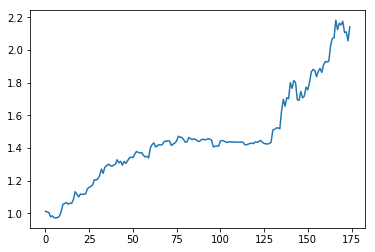

In [16]:
plt.plot(pnl)

Now we test the performance on test set

In [20]:
pnl = np.ones(len(test_return))
for i in range(len(test_return)-8):
    if i%7 == 0:
        if test_return.iloc[i] > 0:
            for j in range(0, 7):
                pnl[i+j+1] = pnl[i+j] * 0.5 * (test_price.iloc[i+j+1] / test_price.iloc[i+j]) + pnl[i+j] * 0.5
        if test_return.iloc[i] < 0:
            for j in range(0, 7):
                pnl[i+j+1] = pnl[i+j] * 0.5 * (2-test_price.iloc[i+j+1] / test_price.iloc[i+j]) + pnl[i+j] * 0.5
pnl = pnl[pnl!=1]

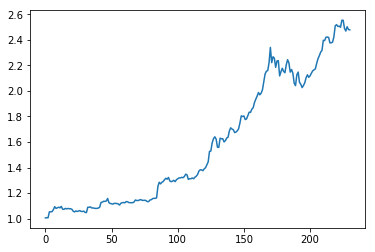

In [21]:
plt.plot(pnl)

Hold-out is the last 25 value of pnl, which acts like the follows:

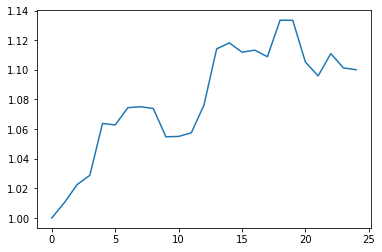

In [22]:
pnl = pnl[-25:]
pnl = pnl/pnl[0]
plt.plot(pnl)
